# **기계학습 중간과제: 클러스터링**
**<div style="text-align: right"> 202120990 김도환 </div>**

#### **목표:**

서울특별시의 전기차 충전소 클러스터링을 통한 전기차 충전소 최적 위치 선정 

<br/>

#### **문제 정의:**

클러스터링 분석을 도시 내 전기차 충전소의 위치와 이용 패턴을 파악하여, 서울특별시 전기차 충전소의 입지 선정에 도움을 줄 수 있습니다.

어느 곳에 위치한 충전소가 사용량이 많은지 군집화하여, 각각 군집의 특성을 파악하고 분석합니다.

예상되는 결과는 다음과 같습니다:

- 서울특별시 내 각 지역의 전기차 충전 인프라 현황을 시각화하여 부족 지역을 확인할 수 있습니다.
- 새로운 충전소 입지를 제안하거나, 기존 충전소의 운영 방식을 개선하는데 필요한 내용을 도출할 수 있습니다.

이를 통해 서울특별시의 전기차 보급과 이용 편의성을 증진시키는데 기여할 수 있을 것으로 기대합니다.

<br/>

#### **사용데이터:**
* 한국환경공단에서 제공하는 [전기차 충전소 위치 및 운영정보 데이터](https://www.data.go.kr/data/15125089/fileData.do)
* 한국환경공단에서 제공하는 [환경부 전기차 충전기 충전량 상세정보 데이터](https://www.data.go.kr/data/15124713/fileData.do)

전기차 충전기 충전량 상세정보 데이터의 경우 2023년도 1월부터 9월까지의 누계 데이터를 사용하였습니다.

<br/>

---

과제를 시작하기 전 사용되는 모듈을 다운로드 합니다.

In [1]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


경고 무시 및 폰트 깨짐 문제 해결, 그래프 컬러 팔레트 지정을 위한 코드를 실행합니다.

In [2]:
# 경고를 무시합니다.
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트를 설정해줍니다. (폰트 깨짐 방지)
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
font_path = './fonts/NanumGothic.ttf'
fm.fontManager.addfont(font_path)
plt.rcParams['font.family'] = 'NanumGothic'

# 컬러 팔레트 지정
import seaborn as sns
my_palette = ["#FF8E7F", "#89A5EA", "#FFCB6B", "#A5EA89"]  # 사용할 컬러 목록

## **1. CSV에서 데이터 불러오기**

한국환경공단에서 제공하는 `전기차 충전소 위치 및 운영정보` 데이터와 `환경부 전기차 충전기 충전량 상세정보` 데이터를 DataFrame으로 불러옵니다.

In [3]:
import pandas as pd

charge_info_df = pd.read_csv("./data/한국환경공단_전기차 충전소 위치 및 운영정보.csv", low_memory=False)
charge_amount_df = pd.read_csv("./data/한국환경공단_환경부 전기차 충전기 충전량 상세정보.csv", low_memory=False)
print("========== 전기차 충전소 정보 ==========")
print(charge_info_df.info())
print("\n========== 전기차 충전소 충전량 ==========")
print(charge_amount_df.info())

========== 전기차 충전소 정보 ==========
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44580 entries, 0 to 44579
Data columns (total 17 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   설치년도     44580 non-null  int64 
 1   시도       44580 non-null  object
 2   군구       44499 non-null  object
 3   주소       44580 non-null  object
 4   충전소명     44580 non-null  object
 5   시설구분(대)  44537 non-null  object
 6   시설구분(소)  44580 non-null  object
 7   기종(대)    44580 non-null  object
 8   기종(소)    44580 non-null  object
 9   운영기관(대)  44580 non-null  object
 10  운영기관(소)  44580 non-null  object
 11  급속충전량    348 non-null    object
 12  충전기타입    44580 non-null  object
 13  이용자제한    44580 non-null  object
 14  충전기ID    44580 non-null  int64 
 15  충전소ID    44580 non-null  object
 16  위도경도     44574 non-null  object
dtypes: int64(2), object(15)
memory usage: 5.8+ MB
None

========== 전기차 충전소 충전량 ==========
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348 entries, 0

전기차 충전소 데이터는 약 4만개, 전기차 충전소 충전량 데이터는 348개 입니다.

전기차 충전소 충전량 데이터는 해당 충전소를 얼마나 자주 이용하는지를 나타내는 지표이기 때문에, 전기차 충전소 충전량 데이터를 기준으로 데이터 병합을 진행합니다.

## **2. 데이터 전처리**
### **2-1. 데이터 병합**

전기차 충전소 정보에 대한 데이터 형식을 확인합니다.

In [4]:
charge_info_df.head(1)

,설치년도,시도,군구,주소,충전소명,시설구분(대),시설구분(소),기종(대),기종(소),운영기관(대),운영기관(소),급속충전량,충전기타입,이용자제한,충전기ID,충전소ID,위도경도
0,2017,서울특별시,강동구,서울특별시 강동구 고덕로28길 36,암사1동 공영주차장,주차시설,공영주차장,급속,급속(50kW),환경부,환경부(협회),급속(50kW),DC차데모+AC3상+DC콤보,이용가능,1,ME174003,"37.5529087,127.1372547"


형태를 확인해보면 위도경도 데이터가 하나의 칼럼에 묶여있는 것을 알 수 있습니다.
해당 칼럼을 위도 칼럼, 경도 칼럼으로 나누어줍니다.

In [5]:
charge_info_df["위도"] = charge_info_df["위도경도"].str.split(",").str[0].astype(float)
charge_info_df["경도"] = charge_info_df["위도경도"].str.split(",").str[1].astype(float)
charge_info_df.head(1)

,설치년도,시도,군구,주소,충전소명,시설구분(대),시설구분(소),기종(대),기종(소),운영기관(대),운영기관(소),급속충전량,충전기타입,이용자제한,충전기ID,충전소ID,위도경도,위도,경도
0,2017,서울특별시,강동구,서울특별시 강동구 고덕로28길 36,암사1동 공영주차장,주차시설,공영주차장,급속,급속(50kW),환경부,환경부(협회),급속(50kW),DC차데모+AC3상+DC콤보,이용가능,1,ME174003,"37.5529087,127.1372547",37.552909,127.137255


이제 충전소ID 칼럼을 기준으로 충전기 충전량 데이터와 충전소 정보 데이터를 합쳐줍니다.

In [6]:
merge_df = pd.merge(charge_amount_df, charge_info_df, how="inner", on="충전소ID")
merge_df.head(1)

,충전소ID,충전기ID_x,2023년 01월 충전횟수,2023년 01월 충전량,2023년 02월 충전횟수,2023년 02월 충전량,2023년 03월 충전횟수,2023년 03월 충전량,2023년 04월 충전횟수,2023년 04월 충전량,...,기종(소),운영기관(대),운영기관(소),급속충전량,충전기타입,이용자제한,충전기ID_y,위도경도,위도,경도
0,ME174003,1,276,5345.11,261,5006.84,200,3731.34,156,2842.94,...,급속(50kW),환경부,환경부(협회),급속(50kW),DC차데모+AC3상+DC콤보,이용가능,1,"37.5529087,127.1372547",37.552909,127.137255


월별로 나누어져 있는 충전횟수 및 충전량 데이터를 평균을 내 새로운 칼럼을 생성합니다.

In [7]:
for i in range(len(merge_df)):
    charge_amount = merge_df.filter(regex='.* 충전량$').loc[i].sum()
    charge_count = merge_df.filter(regex='.* 충전횟수$').loc[i].sum()
    merge_df.loc[i, "총충전량"] = charge_amount
    merge_df.loc[i, "총충전횟수"] = charge_count

In [8]:
merge_df.head(1)

,충전소ID,충전기ID_x,2023년 01월 충전횟수,2023년 01월 충전량,2023년 02월 충전횟수,2023년 02월 충전량,2023년 03월 충전횟수,2023년 03월 충전량,2023년 04월 충전횟수,2023년 04월 충전량,...,운영기관(소),급속충전량,충전기타입,이용자제한,충전기ID_y,위도경도,위도,경도,총충전량,총충전횟수
0,ME174003,1,276,5345.11,261,5006.84,200,3731.34,156,2842.94,...,환경부(협회),급속(50kW),DC차데모+AC3상+DC콤보,이용가능,1,"37.5529087,127.1372547",37.552909,127.137255,33244.11,1733.0


In [9]:
merge_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2090 entries, 0 to 2089
Data columns (total 40 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   충전소ID           2090 non-null   object 
 1   충전기ID_x         2090 non-null   int64  
 2   2023년 01월 충전횟수  2090 non-null   int64  
 3   2023년 01월 충전량   2090 non-null   float64
 4   2023년 02월 충전횟수  2090 non-null   int64  
 5   2023년 02월 충전량   2090 non-null   float64
 6   2023년 03월 충전횟수  2090 non-null   int64  
 7   2023년 03월 충전량   2090 non-null   float64
 8   2023년 04월 충전횟수  2090 non-null   int64  
 9   2023년 04월 충전량   2090 non-null   float64
 10  2023년 05월 충전횟수  2090 non-null   int64  
 11  2023년 05월 충전량   2090 non-null   float64
 12  2023년 06월 충전횟수  2090 non-null   int64  
 13  2023년 06월 충전량   2090 non-null   float64
 14  2023년 07월 충전횟수  2090 non-null   int64  
 15  2023년 07월 충전량   2090 non-null   float64
 16  2023년 08월 충전횟수  2090 non-null   int64  
 17  2023년 08월 충전량   2090 non-null   f

### **2-2. 데이터셋에 사용할 특성만 추출**

위 데이터의 특성 중 군집화에 도움이 될 만한 특성만 추출합니다.
저는 `급속충전량`, `충전기타입`, `이용자제한`, `시설구분(소)`, `운영기관(소)`, `위도`, `경도`, `총충전량`, `총충전횟수`를 군집화 특성으로 추출하였습니다.
여기에서 `총충전량`과 `총충전횟수`는 충전소의 사용도를 나타내는 중요한 변수로 작용할 것으로 예상됩니다.

In [10]:
dataset = merge_df[[
    "급속충전량", 
    "충전기타입", 
    "이용자제한", 
    "시설구분(소)", 
    "운영기관(소)", 
    "위도", 
    "경도", 
    "총충전량",
    "총충전횟수"
]]

### **2-3. 범주형 데이터에 대한 원-핫 인코딩**

범주형 데이터에 대해서 처리 가능하도록 원-핫 인코딩(One-Hot Encoding)을 진행하였습니다.

In [11]:
X = pd.get_dummies(data=dataset, columns=["급속충전량", "충전기타입", "이용자제한", "시설구분(소)", "운영기관(소)"])
X.head()

,위도,경도,총충전량,총충전횟수,급속충전량_급속(100kW단독),급속충전량_급속(100kW동시),급속충전량_급속(100kW멀티),급속충전량_급속(200kW동시),급속충전량_급속(400kW동시),급속충전량_급속(50kW),...,시설구분(소)_서비스센터,시설구분(소)_숙박시설,시설구분(소)_일반주차장,시설구분(소)_전시관,시설구분(소)_주민센터,시설구분(소)_지자체시설,시설구분(소)_학교,시설구분(소)_홍보관,시설구분(소)_환승주차장,운영기관(소)_환경부(협회)
0,37.552909,127.137255,33244.11,1733.0,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,True
1,37.544812,127.121840,32004.17,1758.0,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,True
2,37.538795,127.133399,19134.38,993.0,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,True
3,37.537263,126.838379,16962.38,761.0,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,True
4,37.528956,126.849089,37188.74,1923.0,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,True


최종적으로 생성된 특성은 다음과 같습니다.

In [12]:
X.columns

Index(['위도', '경도', '총충전량', '총충전횟수', '급속충전량_급속(100kW단독)', '급속충전량_급속(100kW동시)',
       '급속충전량_급속(100kW멀티)', '급속충전량_급속(200kW동시)', '급속충전량_급속(400kW동시)',
       '급속충전량_급속(50kW)', '급속충전량_완속(30kW단독)', '급속충전량_초급속(350kW단독)',
       '충전기타입_DC차데모+AC3상+DC콤보', '충전기타입_DC차데모+DC콤보', '충전기타입_DC콤보',
       '충전기타입_DC콤보(완속)', '이용자제한_이용가능', '이용자제한_이용자제한', '시설구분(소)_경찰서',
       '시설구분(소)_고속도로 휴게소', '시설구분(소)_공공기관', '시설구분(소)_공영주차장', '시설구분(소)_공원',
       '시설구분(소)_공원주차장', '시설구분(소)_공중전화부스', '시설구분(소)_관공서', '시설구분(소)_관광안내소',
       '시설구분(소)_관광지', '시설구분(소)_관람장', '시설구분(소)_금융기관', '시설구분(소)_도서관',
       '시설구분(소)_마트(쇼핑몰)', '시설구분(소)_박물관', '시설구분(소)_백화점', '시설구분(소)_병원',
       '시설구분(소)_복지관', '시설구분(소)_사업장(사옥)', '시설구분(소)_서비스센터', '시설구분(소)_숙박시설',
       '시설구분(소)_일반주차장', '시설구분(소)_전시관', '시설구분(소)_주민센터', '시설구분(소)_지자체시설',
       '시설구분(소)_학교', '시설구분(소)_홍보관', '시설구분(소)_환승주차장', '운영기관(소)_환경부(협회)'],
      dtype='object')

## **3. 데이터 클러스터링**
### **3-1. K-Means Clustering**

K-Means Clustering 알고리즘을 사용해 군집화를 진행합니다.

클러스터 수는 3으로 설정하였고, 랜덤 시드 값은 0으로 설정하였습니다.

In [13]:
# KMeans 클러스터링 알고리즘 임포트
from sklearn.cluster import KMeans

# 클러스터 수와 랜덤 시드 설정
nclusters = 3
seed = 0

# KMeans 모델 생성 및 훈련
km = KMeans(n_clusters=nclusters, random_state=seed)
km.fit(X)

# 각 데이터 포인트의 클러스터 예측
y_cluster_kmeans = km.predict(X)
y_cluster_kmeans

array([2, 2, 1, ..., 0, 0, 0], dtype=int32)

실루엣 스코어를 계산합니다.

In [14]:
# sklearn.metrics 모듈 임포트
from sklearn import metrics

# Silhouette Score 계산
score = metrics.silhouette_score(X, y_cluster_kmeans)
print(f"Silhouette Score: {score}")

Silhouette Score: 0.8247699797018119


실루엣 스코어를 확인해보면 상당히 높은 것을 알 수 있습니다.

### **3-2. Elbow 방법을 사용해 최적의 클러스터 수 결정**

최적의 군집 수를 구하기 위해 Elbow 방법을 사용합니다.

클러스터 간의 거리의 합을 나타내는 `inertia`가 급격히 떨어지는 구간을 확인합니다.

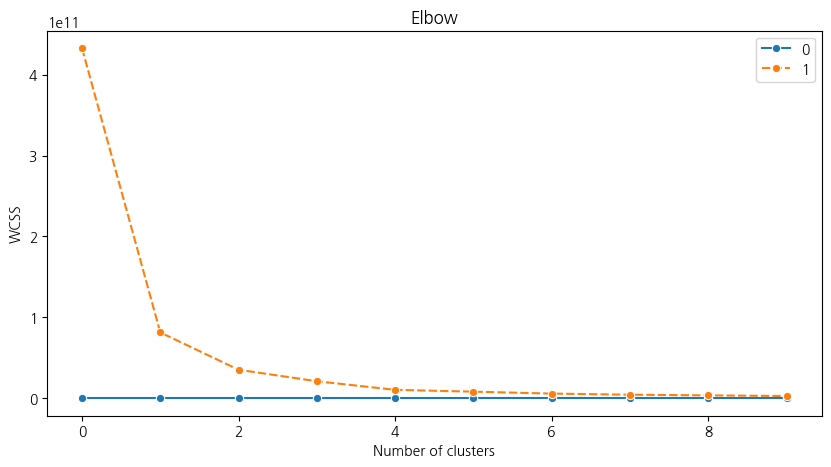

In [15]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10,5))
sns.lineplot(data=(range(1, 11), wcss), marker='o', color='red')
plt.title('Elbow')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

위 그래프에 의하면 K 값은 2 또는 3, 4가 적당해 보입니다.

### **3-3. 결정된 k 값으로 클러스터링 수정 및 평가**

Elbow 방법을 통해 k 값을 4로 지정해주었습니다. 이제 수정된 k 값으로 K-Means 클러스터링을 다시 진행합니다.

Silhouette Score: 0.8247868750794658


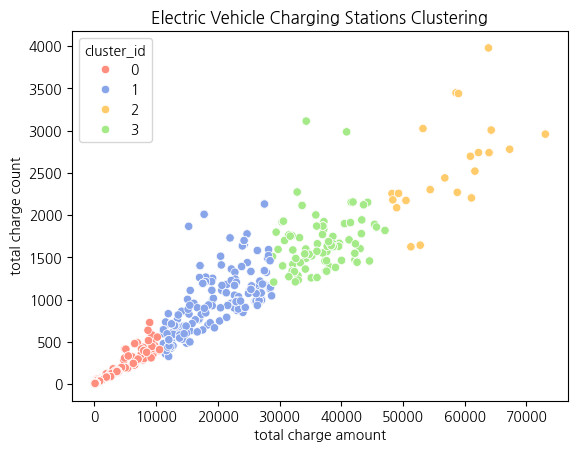

In [23]:
# KMeans 클러스터링 알고리즘 임포트
from sklearn.cluster import KMeans


# KMeans 모델 생성 및 훈련
kmeans = KMeans(n_clusters=4, random_state=seed)
kmeans.fit(X)

# 각 데이터 포인트의 클러스터 레이블 예측
labels = kmeans.predict(X)

dataset["cluster_id"] = labels

# Silhouette Score 계산
score = metrics.silhouette_score(X, labels)
print(f"Silhouette Score: {score}")

# Scatter plot 그리기
sns.scatterplot(x="총충전량", y="총충전횟수", data=dataset, hue="cluster_id", palette=my_palette)

# x축 및 y축 라벨 설정
plt.title('Electric Vehicle Charging Stations Clustering')
plt.xlabel("total charge amount")
plt.ylabel("total charge count")

# 그래프 출력
plt.show()

실루엣 점수를 확인해보면 0.82정도로 상당히 높은 것을 확인할 수 있습니다.

군집화의 경우 빨간색, 노란색, 파란색, 초록색으로 네 개의 그룹이 생성되었습니다. 각각의 군집은 다음과 같은 의미를 갖습니다.

- `빨간색(0)`: 사용량이 매우 적은 충전소
- `파란색(1)`: 사용량이 적은 충전소
- `초록색(3)`: 사용량이 많은 충전소
- `노란색(2)`: 사용량이 매우 많은 충전소

 각각의 군집을 살펴보도록 하겠습니다.

 ## **4. 결과 분석**

군집 분석을 진행하기 전, 클러스터링에 사용된 데이터셋의 양이 많은 것이 아니라 분석 결과를 일반화하기에는 어려움이 있을 수 있습니다. 이는 추후 데이터를 늘려 분석 결과에 신뢰도를 높일 수 있을 것으로 기대됩니다.

 ### **4-1. 군집별 급속충전량**

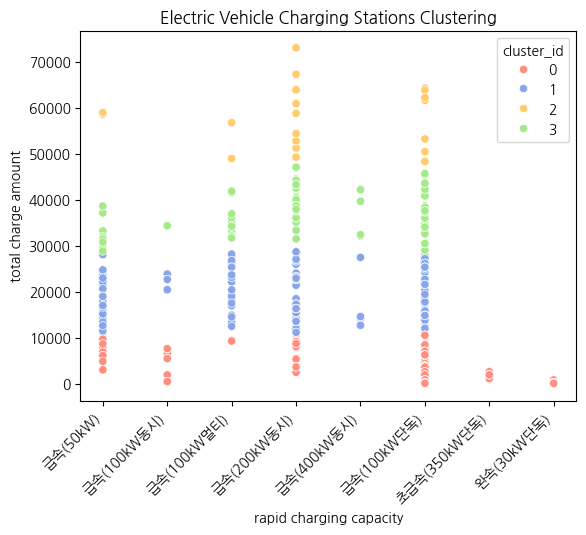

In [24]:
# Scatter plot 그리기
sns.scatterplot(x="급속충전량", y="총충전량", data=dataset, hue="cluster_id", palette=my_palette)

# x축 및 y축 라벨 설정
plt.title('Electric Vehicle Charging Stations Clustering')
plt.xlabel("rapid charging capacity")
plt.ylabel("total charge amount")
plt.xticks(rotation=45, ha="right")

# 그래프 출력
plt.show()

먼저, 군집별 급속충전량을 확인해보았습니다. `초급속` 충전기가 설치된 충전소의 사용량이 낮은 것을 확인할 수 있었고, `완속` 충전기의 사용량도 매우 낮은 것을 확인할 수 있습니다. `완속` 충전기를 잘 사용하지 않는 것은 어찌보면 당연한 결과로 보여질 수 있으나, `초급속` 충전기의 사용량이 저조한 것은 의외의 결과라고 할 수 있습니다.
이는 최적의 입지 선정에 실패한 충전소라고 볼 수 있습니다.


### **4-2. 군집별 설치 장소**

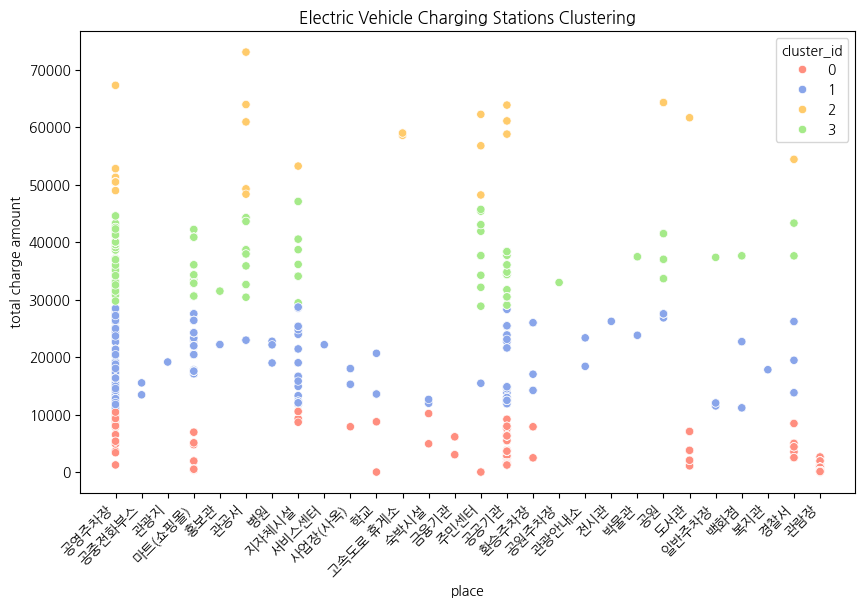

In [25]:
# Scatter plot 그리기
plt.figure(figsize=(10, 6))
sns.scatterplot(x="시설구분(소)", y="총충전량", data=dataset, hue="cluster_id", palette=my_palette)

# x축 및 y축 라벨 설정
plt.title('Electric Vehicle Charging Stations Clustering')
plt.xlabel("place")
plt.ylabel("total charge amount")
plt.xticks(rotation=45, ha="right")

# 그래프 출력
plt.show()

군집별 설치 장소를 확인해보면, `학교`와 `숙박시설`, `금융기관`, `관람장`의 경우 충전소의 사용량이 매우 낮음을 알 수 있습니다. 전체적으로 높은 사용량을 띄는 장소는 `관공서`와 `지자체시설`, `공원`이며, 그 외의 장소는 사용량이 낮은 충전소와 높은 충전소가 같이 분포해 있는 것을 확인할 수 있습니다.

### **4-3. 지도상에 시각화**

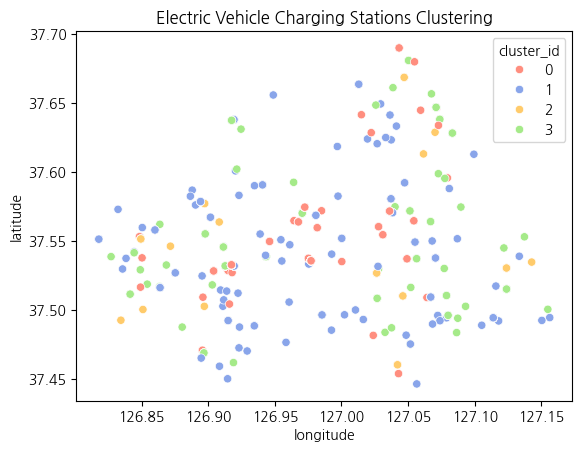

In [60]:
# Scatter plot 그리기
sns.scatterplot(x="경도", y="위도", data=dataset, hue="cluster_id", palette=my_palette)

# x축 및 y축 라벨 설정
plt.title('Electric Vehicle Charging Stations Clustering')
plt.xlabel("longitude")
plt.ylabel("latitude")

# 그래프 출력
plt.show()

x축을 경도로, y축을 위도로 설정하여 시각화하였습니다.
전반적으로 고르게 분포해 있지만, 충전소가 부족해 보이는 지역도 분명 존재하는 것을 알 수 있습니다.

조금 더 직관적으로 알 수 있도록 히트맵을 통해 시각화를 진행합니다.

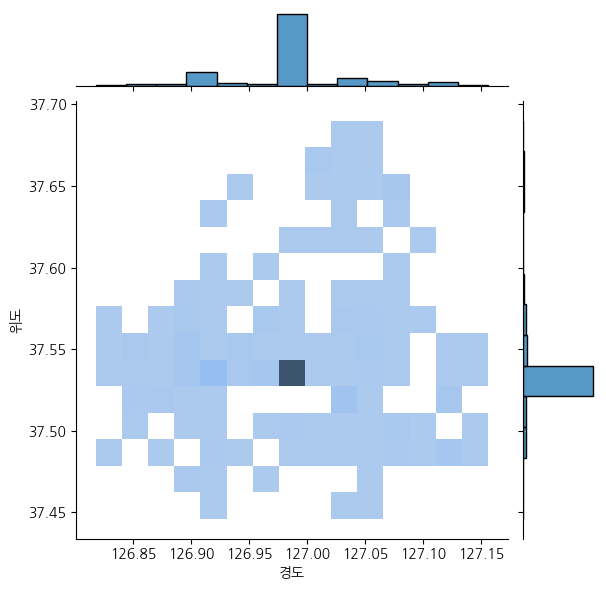

In [48]:
sns.jointplot(x=dataset["경도"], y=dataset["위도"], kind="hist", bins=15)

# 그래프 출력
plt.show()

위 그래프는 특정 거리를 기준으로 격자를 나눈 후, 격자에 속한 전기차 충전소 개수를 시각화 한 그래프입니다.
전반적으로 고르게 분포해 있지만, 특정 지역에 밀집해 있는 것을 알 수 있습니다.

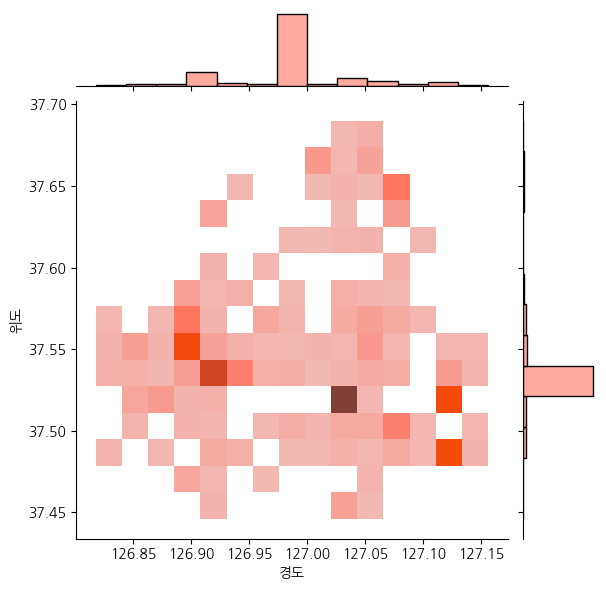

In [59]:
sns.jointplot(x=dataset["경도"], y=dataset["위도"], kind="hist", bins=15, weights=dataset["총충전량"], color="#FF8E7F")

# 그래프 출력
plt.show()

전기차 충전소 개수를 기준으로 시각화하지 않고, 대신 총 충전량을 기준으로 시각화 한 결과를 살펴보면, 위와 같은 그래프가 생성됩니다.
처음 그래프와 비교했을 때, 충전소가 밀집된 지역의 총 충전량은 상대적으로 낮은 것을 알 수 있습니다. 이는 충전소의 밀집도가 높을수록 각 충전소당 평균 충전량이 감소하는 경향이 있음을 시사합니다.

또한 충전량이 집중되는 지역에서는 충전소 개수가 상대적으로 적은 것을 고려할 때, 해당 지역에는 추가적인 충전소가 필요할 것으로 보입니다. 이러한 정보를 토대로 해당 지역에 적절한 위치에 충전소를 추가 배치함으로써 전기차 사용자들의 이용 편의성을 향상시킬 수 있을 것으로 기대됩니다.

In [61]:
import folium

map_osm = folium.Map(location=[37.569819, 126.993895], zoom_start=11)
# 배경지도 타일 설정하기
tiles = "CartoDB positron"
# 배경지도 타일 레이어를 지도에 추가하기
folium.TileLayer(tiles=tiles).add_to(map_osm)

for i in range(len(X)):
    folium.CircleMarker(
        [X.loc[i]["위도"], X.loc[i]["경도"]],
        radius=5.0,
        color=my_palette[labels[i]],
        fill=True       
    ).add_to(map_osm)
map_osm

마지막으로, 실제 지도 위에 군집화한 클러스터링 데이터를 표시하였습니다.